In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from pathlib import Path
import networkx as nx
import os
import pickle
import hashlib
from sklearn.preprocessing import LabelEncoder
import numpy as np

import pandas as pd

In [2]:
ver = '337'
csv_file_path = './csv_files/' + ver
ver = '_'+ ver + '_'
all_transactions_df = pd.read_csv(csv_file_path+'/all_transactions'+ver+'.csv', index_col=0)
all_transactions_df.head()

print(len(all_transactions_df))

all_taxpayers_df = pd.read_csv(csv_file_path+'/all_taxpayers'+ver+'.csv', index_col=0)
all_taxpayers_df.head()
print(len(all_taxpayers_df))

176192
10100


In [6]:
all_transactions_df.columns

for col in ['description_of_goods', 'invoice_status', 'payment_method']:
    encoder = LabelEncoder()
    all_transactions_df[col + '_encoded'] = encoder.fit_transform(all_transactions_df[col])


all_transactions_df['day_of_week'] = pd.to_datetime(all_transactions_df['invoice_date']).dt.weekday
all_transactions_df['month'] = pd.to_datetime(all_transactions_df['invoice_date']).dt.month


all_transactions_df['month_sin'] = np.sin(2 * np.pi * all_transactions_df['month'] / 12)
all_transactions_df['month_cos'] = np.cos(2 * np.pi * all_transactions_df['month'] / 12)

edge_features = [
       'description_of_goods_encoded', 'invoice_status_encoded',
       'payment_method_encoded', 'day_of_week', 'month', 'month_sin',
       'month_cos']

In [7]:
# 1. Encode node IDs
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, StandardScaler

all_taxpayers = pd.unique(all_transactions_df[['buyer_id', 'seller_id']].values.ravel())
node_encoder = {tid: i for i, tid in enumerate(all_taxpayers)}
n_nodes = len(all_taxpayers)

# 2. Edge index
edge_index = torch.tensor([
    all_transactions_df['seller_id'].map(node_encoder).values,
    all_transactions_df['buyer_id'].map(node_encoder).values
], dtype=torch.long)

# 3. Edge labels (declared = 1 or 0)
edge_label = torch.tensor(all_transactions_df['declared'].values, dtype=torch.float)

# 4. Create node features (e.g., size, region, activity)
taxpayer_info = all_taxpayers_df.set_index('taxpayer_id').loc[all_taxpayers]
node_features = pd.get_dummies(taxpayer_info[['location', 'economic_sector', 'size_category']])
node_features['size'] = taxpayer_info['size'].values
scaler = StandardScaler()
x = torch.tensor(scaler.fit_transform(node_features.values), dtype=torch.float)


edge_features_df = all_transactions_df[edge_features]
edge_attr = torch.tensor(edge_features_df.values, dtype=torch.float)


# 5. Wrap in PyG Data object
data = Data(
    x=x,                 # node features
    edge_index=edge_index,
    edge_attr=edge_attr, # edge features
    edge_label=edge_label # edge labels for classification
)


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3581/2970169052.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor([


In [12]:
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of node features: {data.num_node_features}")
print(f"Number of edge features: {data.edge_attr.shape[1] if data.edge_attr is not None else 0}")
print(f"Edge label shape: {data.edge_label.shape if data.edge_label is not None else 'None'}")
print(f"Node Features: {node_features.columns}")
print(f"Edge Features: {edge_features_df.columns}")


Number of nodes: 10097
Number of edges: 176192
Number of node features: 40
Number of edge features: 7
Edge label shape: torch.Size([176192])
Node Features: Index(['location_Eldoret', 'location_Garissa', 'location_Kericho',
       'location_Kisumu', 'location_Kitale', 'location_Machakos',
       'location_Meru', 'location_Mombasa', 'location_Nairobi',
       'location_Nakuru', 'location_Nyeri', 'location_Thika',
       'economic_sector_Agriculture', 'economic_sector_Arts & Culture',
       'economic_sector_Construction', 'economic_sector_Education',
       'economic_sector_Energy', 'economic_sector_Entertainment & Media',
       'economic_sector_Finance', 'economic_sector_Healthcare',
       'economic_sector_Hospitality', 'economic_sector_ICT',
       'economic_sector_Legal & Professional Services',
       'economic_sector_Manufacturing', 'economic_sector_Mining & Quarrying',
       'economic_sector_Public Administration', 'economic_sector_Real Estate',
       'economic_sector_Retail', 

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Convert PyG Data to NetworkX graph
G = to_networkx(data, to_undirected=True)  # undirected for easier visualization

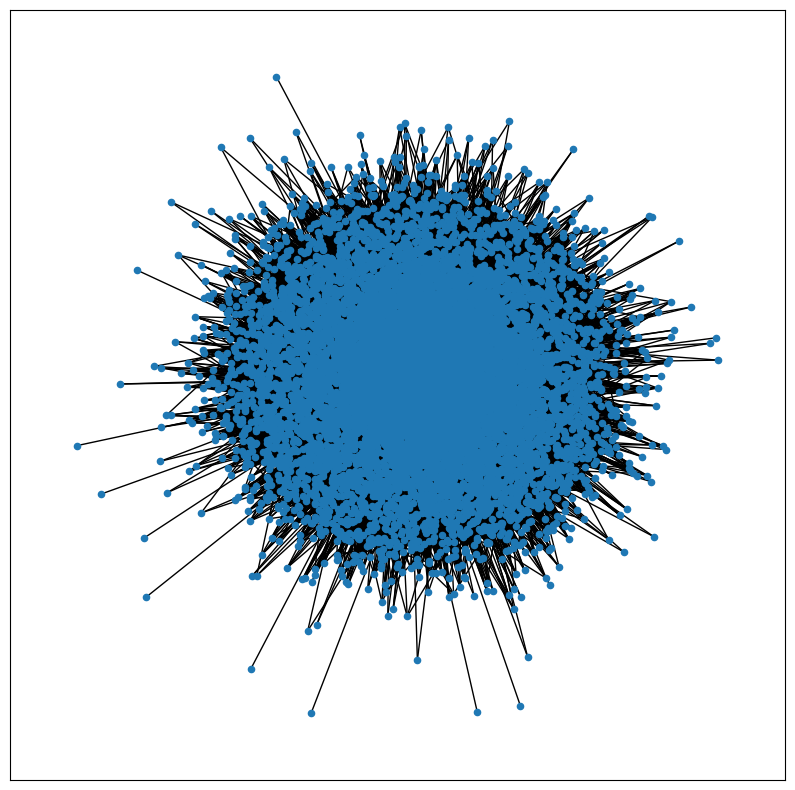

In [16]:
# Draw graph (simple)
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, node_size=20, with_labels=False)
plt.show()


In [17]:
import networkx as nx
import numpy as np

# Assume you have this:
# G = to_networkx(data, to_undirected=True)

def describe_graph(G):
    print("📊 Basic Graph Properties")
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G) #which is a measure of how many edges are in the graph compared to the maximum possible number of edges.
    degrees = [deg for _, deg in G.degree()]
    avg_degree = np.mean(degrees) # average degree of a graph tells you how many edges each node has on average 
    degree_distribution = np.bincount(degrees)

    print(f"- Number of nodes: {num_nodes}")
    print(f"- Number of edges: {num_edges}")
    print(f"- Density: {density:.4f}")
    print(f"- Average degree: {avg_degree:.2f}")
    print(f"- Degree distribution (sample): {dict(zip(*np.unique(degrees, return_counts=True)))}")

    print("\n🔗 Connectivity Metrics")
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        avg_path_length = nx.average_shortest_path_length(G)
        print(f"- Diameter: {diameter}")
        print(f"- Average path length: {avg_path_length:.2f}")
    else:
        num_components = nx.number_connected_components(G)
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        diameter = nx.diameter(subgraph)
        avg_path_length = nx.average_shortest_path_length(subgraph)
        print(f"- Connected components: {num_components}")
        print(f"- Diameter (of largest component): {diameter}")
        print(f"- Average path length (largest component): {avg_path_length:.2f}")

    clustering_coeff = nx.average_clustering(G)
    transitivity = nx.transitivity(G)
    print(f"- Average clustering coefficient: {clustering_coeff:.4f}")
    print(f"- Transitivity: {transitivity:.4f}")



In [18]:
describe_graph(G)

📊 Basic Graph Properties
- Number of nodes: 10097
- Number of edges: 135359
- Density: 0.0027
- Average degree: 26.81
- Degree distribution (sample): {1: 11, 2: 35, 3: 82, 4: 179, 5: 268, 6: 366, 7: 430, 8: 444, 9: 404, 10: 363, 11: 372, 12: 304, 13: 334, 14: 320, 15: 305, 16: 354, 17: 313, 18: 303, 19: 365, 20: 328, 21: 284, 22: 275, 23: 239, 24: 259, 25: 195, 26: 196, 27: 195, 28: 181, 29: 142, 30: 143, 31: 111, 32: 114, 33: 117, 34: 96, 35: 100, 36: 92, 37: 91, 38: 81, 39: 83, 40: 73, 41: 50, 42: 50, 43: 44, 44: 71, 45: 55, 46: 34, 47: 45, 48: 43, 49: 42, 50: 33, 51: 33, 52: 22, 53: 28, 54: 26, 55: 18, 56: 12, 57: 20, 58: 18, 59: 13, 60: 14, 61: 16, 62: 9, 63: 10, 64: 7, 65: 13, 66: 12, 67: 13, 68: 18, 69: 8, 70: 9, 71: 7, 72: 8, 73: 5, 74: 7, 75: 9, 76: 5, 77: 2, 78: 6, 79: 2, 80: 2, 81: 3, 82: 2, 83: 5, 84: 8, 85: 7, 86: 3, 87: 3, 88: 1, 89: 7, 90: 6, 91: 3, 93: 2, 94: 3, 95: 5, 96: 1, 97: 4, 98: 3, 99: 2, 101: 6, 102: 7, 103: 2, 104: 2, 105: 3, 106: 3, 107: 3, 108: 2, 109: 6, 110

In [20]:
#split the edges into training and testing
from sklearn.model_selection import train_test_split
import torch

# 1. Get edge data
edges = data.edge_index.t().numpy()              # shape: [num_edges, 2]
labels = data.edge_label.numpy()                 # shape: [num_edges]
edge_attrs = data.edge_attr.numpy()              # shape: [num_edges, num_edge_features]

# 2. Train/val/test split with edge_attr included
X_train, X_temp, y_train, y_temp, attr_train, attr_temp = train_test_split(
    edges, labels, edge_attrs, test_size=0.3, stratify=labels, random_state=42
)

X_val, X_test, y_val, y_test, attr_val, attr_test = train_test_split(
    X_temp, y_temp, attr_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# 3. Convert to torch tensors
def to_torch_edges(edges, labels, attrs):
    edge_index = torch.tensor(edges).t().contiguous()                # shape: [2, num_edges]
    edge_label = torch.tensor(labels, dtype=torch.float)             # shape: [num_edges]
    edge_attr = torch.tensor(attrs, dtype=torch.float)               # shape: [num_edges, num_edge_features]
    return edge_index, edge_label, edge_attr

train_edge_index, train_edge_label, train_edge_attr = to_torch_edges(X_train, y_train, attr_train)
val_edge_index, val_edge_label, val_edge_attr = to_torch_edges(X_val, y_val, attr_val)
test_edge_index, test_edge_label, test_edge_attr = to_torch_edges(X_test, y_test, attr_test)



In [21]:
#the GraphSage Model
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from torch import nn

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


In [23]:
#The Edge Classifier
import torch.nn as nn
import torch.nn.functional as F

class EdgeClassifier(nn.Module):
    def __init__(self, emb_dim, edge_feat_dim):
        super(EdgeClassifier, self).__init__()
        self.fc1 = nn.Linear(2 * emb_dim + edge_feat_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, z, edge_index, edge_attr):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        x = torch.cat([src, dst, edge_attr], dim=1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x)).squeeze()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assume edge_attr has already been split: train_edge_attr, val_edge_attr
# and edge_classifier expects edge_attr as input

model = GraphSAGE(in_channels=data.num_node_features, hidden_channels=64).to(device)
edge_classifier = EdgeClassifier(emb_dim=64, edge_feat_dim=train_edge_attr.shape[1]).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(edge_classifier.parameters()),
    lr=0.005
)
loss_fn = nn.BCELoss()

data = data.to(device)

# Move edge splits to device
train_edge_index = train_edge_index.to(device)
train_edge_label = train_edge_label.to(device)
train_edge_attr = train_edge_attr.to(device)

val_edge_index = val_edge_index.to(device)
val_edge_label = val_edge_label.to(device)
val_edge_attr = val_edge_attr.to(device)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()

    # 1. Compute node embeddings
    z = model(data.x, data.edge_index)

    # 2. Predict edge labels using edge classifier
    pred = edge_classifier(z, train_edge_index, train_edge_attr)

    # 3. Compute loss and backprop
    loss = loss_fn(pred, train_edge_label)
    loss.backward()
    optimizer.step()

    # 4. Evaluate every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = edge_classifier(z, val_edge_index, val_edge_attr)
            val_loss = loss_fn(val_pred, val_edge_label)
            val_acc = ((val_pred > 0.5) == val_edge_label).float().mean()
            print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")


Epoch 010 | Train Loss: 0.3334 | Val Acc: 0.8769
Epoch 020 | Train Loss: 0.1860 | Val Acc: 0.9249
Epoch 030 | Train Loss: 0.1450 | Val Acc: 0.9449
Epoch 040 | Train Loss: 0.1321 | Val Acc: 0.9468
Epoch 050 | Train Loss: 0.1248 | Val Acc: 0.9493
Epoch 060 | Train Loss: 0.1202 | Val Acc: 0.9519
Epoch 070 | Train Loss: 0.1173 | Val Acc: 0.9521
Epoch 080 | Train Loss: 0.1151 | Val Acc: 0.9523
Epoch 090 | Train Loss: 0.1137 | Val Acc: 0.9522
Epoch 100 | Train Loss: 0.1371 | Val Acc: 0.9504


In [25]:
# Inference on test set
model.eval()
with torch.no_grad():
    z = model(data.x, data.edge_index)
    test_pred = edge_classifier(z, test_edge_index, test_edge_attr)

# Convert to numpy
true_labels = test_edge_label.cpu().numpy().astype(int)
predicted_probs = test_pred.cpu().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)

# Compute metrics for undeclared transactions (class 0 as positive)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, average_precision_score
)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, pos_label=0)
recall = recall_score(true_labels, predicted_labels, pos_label=0)
f1 = f1_score(true_labels, predicted_labels, pos_label=0)
roc_auc = roc_auc_score(true_labels, predicted_probs)
pr_auc = average_precision_score(true_labels, predicted_probs, pos_label=0)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display results
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision (class 0):{precision:.4f}")
print(f"Recall (class 0):   {recall:.4f}")
print(f"F1 Score (class 0): {f1:.4f}")
print(f"ROC AUC:            {roc_auc:.4f}")
print(f"PR AUC (class 0):   {pr_auc:.4f}")

import pandas as pd
conf_df = pd.DataFrame(
    conf_matrix,
    index=["Actual: Undeclared", "Actual: Declared"],
    columns=["Predicted: Undeclared", "Predicted: Declared"]
)
print("Confusion Matrix:\n", conf_df)


Accuracy:           0.9396
Precision (class 0):0.8587
Recall (class 0):   0.6101
F1 Score (class 0): 0.7133
ROC AUC:            0.9718
PR AUC (class 0):   0.0648
Confusion Matrix:
                     Predicted: Undeclared  Predicted: Declared
Actual: Undeclared                   1987                 1270
Actual: Declared                      327                22845


In [26]:
torch.save({
    'model_state_dict': model.state_dict(),
    'graph_data': data,
}, 'model_and_graph.pt')


In [ ]:
import pandas as pd

# Map node indices back to taxpayer IDs
node_decoder = {v: k for k, v in node_encoder.items()}  # Reverse of node_encoder

# Convert predictions and labels
pred_probs = test_pred.cpu().numpy().flatten()
pred_labels = (test_pred > 0.5).long().cpu().numpy().flatten()
true_labels = test_edge_label.cpu().numpy().flatten()

# Convert node indices back to taxpayer IDs
seller_ids = [node_decoder[idx] for idx in X_test[:, 0]]
buyer_ids = [node_decoder[idx] for idx in X_test[:, 1]]

# Create the DataFrame
test_results_df = pd.DataFrame({
    'seller_id': seller_ids,
    'buyer_id': buyer_ids,
    'true_label': true_labels,
    'predicted_label': pred_labels,
    'predicted_prob': pred_probs
})

# Optional: sort by confidence
test_results_df = test_results_df.sort_values(by='predicted_prob', ascending=False)

# Show sample
print(test_results_df[test_results_df['predicted_label'] == 0].head())
